# Datos necesarios de pre carga + input inicial

### 1. Cargar los mapas JSON

In [ ]:
import json

# Cargar mapas
with open("mapa_zona.json", 'r') as f:
    mapa_zona = json.load(f)
    mapa_zona = {int(k): v for k, v in mapa_zona.items()}

with open("mapa_sector.json", 'r') as f:
    mapa_sector = json.load(f)
    mapa_sector = {int(k): v for k, v in mapa_sector.items()}

with open("mapa_tipo_ocurrencia.json", 'r') as f:
    mapa_tipo_ocurrencia = json.load(f)
    mapa_tipo_ocurrencia = {int(k): v for k, v in mapa_tipo_ocurrencia.items()}

with open("sector_a_zona.json", 'r') as f:
    sector_a_zona = json.load(f)

with open("mapa_grupo.json", "r", encoding="utf-8") as f:
    mapa_grupo = json.load(f)

### 2. Crear los mapas inversos

In [ ]:
mapa_zona_inverso = {v: k for k, v in mapa_zona.items()}
mapa_sector_inverso = {v: k for k, v in mapa_sector.items()}
mapa_tipo_ocurrencia_inverso = {v: k for k, v in mapa_tipo_ocurrencia.items()}
mapa_grupo_inverso = {v: k for k, v in mapa_grupo.items()}

ver si esta bien:

In [ ]:
# Verificamos parte del diccionario
print("Ejemplo mapa grupo:")
for k in list(mapa_grupo.items())[:14]:
    print(k)

Ejemplo mapa grupo:
('0', 'Actos Obsenos')
('1', 'Alteración del orden en vía pública')
('2', 'Ambiente y limpieza')
('3', 'Animales')
('4', 'Apoyo y asistencia')
('5', 'Consumo de sustancias')
('6', 'Emergencias')
('7', 'Escándalo público')
('8', 'Incidentes escolares')
('9', 'Obstrucción vía pública')
('10', 'Robos')
('11', 'Seguridad ciudadana')
('12', 'Tránsito')
('13', 'Violencia')


### 3. Definir la función transformar_input_real

In [ ]:
def transformar_input_real(año, mes, día, nombre_dia, turno, sector_nombre):
    # Codificar día de la semana
    dias_traducidos = {
        'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3,
        'Viernes': 4, 'Sábado': 5, 'Domingo': 6
    }
    dia_semana_cod = dias_traducidos[nombre_dia]
    es_fin_semana = 1 if dia_semana_cod in [5, 6] else 0

    # Codificar turno
    orden_turno = {'Mañana': 1, 'Tarde': 2, 'Noche': 3}
    turno_cod = orden_turno[turno]

    # Codificar sector
    sector_cod = mapa_sector_inverso.get(sector_nombre, -1)

    # Buscar zona correspondiente al sector
    zona_nombre = sector_a_zona.get(sector_nombre)
    zona_cod = mapa_zona_inverso.get(zona_nombre, -1)

    # Retornar en formato que espera el modelo
    return {
        'año': año,
        'mes': mes,
        'día': día,
        'dia_semana_cod': dia_semana_cod,
        'es_fin_semana': es_fin_semana,
        'turno_cod': turno_cod,
        'sector_cod': sector_cod,
        'zona_cod': zona_cod
    }


### 4. ejemplo de uso

In [ ]:
entrada = transformar_input_real(
    año=2025,
    mes=6,
    día=14,
    nombre_dia='Viernes',
    turno='Tarde',
    sector_nombre='Sto.Dominguito'
)

print(entrada)

{'año': 2025, 'mes': 6, 'día': 14, 'dia_semana_cod': 4, 'es_fin_semana': 0, 'turno_cod': 2, 'sector_cod': 53, 'zona_cod': 1}


# Puesta en marcha del modelo base

In [ ]:
!pip install tensorflow

In [ ]:
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Cargar modelos desde carpeta local
modelo_nn = load_model("modelo_nn_optimo.keras")

# 1. Transformar entrada real
entrada = transformar_input_real(
    año=2025,
    mes=6,
    día=14,
    nombre_dia='Viernes',
    turno='Tarde',
    sector_nombre='Sto.Dominguito'
)

print("Entrada transformada:")
print(entrada)

# preparar variables para la red
categorical_cols = ['turno_cod', 'sector_cod', 'zona_cod', 'dia_semana_cod']
numeric_cols = ['año', 'mes', 'día', 'es_fin_semana']
target_col = 'grupo_incidente_cod'

# 3. Top-5 con RED NEURONAL
entrada_cat = [np.array([entrada[col]]) for col in categorical_cols]
entrada_num = np.array([[entrada[col] for col in numeric_cols]])

probas_nn = modelo_nn.predict(entrada_cat + [entrada_num], verbose=0)

top5_idx_nn = np.argsort(probas_nn[0])[::-1][:5]
top5_probs_nn = probas_nn[0][top5_idx_nn]

# Convertir índices a strings para buscar en el JSON
top5_grupos_nn = [mapa_grupo.get(str(i), f"Clase {i}") for i in top5_idx_nn]


print("\n-> Top-5 predicción con Red Neuronal optima:")
for i, (grupo, prob) in enumerate(zip(top5_grupos_nn, top5_probs_nn), 1):
    print(f"{i}. {grupo} ({prob*100:.2f}%)")

Entrada transformada:
{'año': 2025, 'mes': 6, 'día': 14, 'dia_semana_cod': 4, 'es_fin_semana': 0, 'turno_cod': 2, 'sector_cod': 53, 'zona_cod': 1}

-> Top-5 predicción con Red Neuronal optima:
1. Consumo de sustancias (36.12%)
2. Apoyo y asistencia (15.40%)
3. Seguridad ciudadana (11.60%)
4. Tránsito (9.40%)
5. Escándalo público (9.22%)


# Nuevo input

### De json a df input

In [ ]:
import pandas as pd
import calendar

def crear_dataframe_feedback(data_json, sector_a_zona):
    registros = []

    for item in data_json:
        # Extraer fecha desde input_data["fecha"]
        fecha_str = item["input_data"]["fecha"]  # formato: "DD-MM-YYYY"
        dia, mes, año = map(int, fecha_str.split("-"))
        dia_nombre = calendar.day_name[pd.Timestamp(f"{año}-{mes:02d}-{dia:02d}").dayofweek]
        dia_nombre = traducir_dia_a_espanol(dia_nombre)

        turno = item["input_data"]["turno"]
        sector = item["input_data"]["sector"]
        zona = sector_a_zona.get(sector, "Zona desconocida")

        incidentes = item["actual_incident"]
        for incidente in incidentes:
            registros.append({
                "año": año,
                "mes": mes,
                "día": dia,
                "día_nombre": dia_nombre,
                "turno": turno,
                "sector": sector,
                "zona": zona,
                "incidente": incidente
            })

    return pd.DataFrame(registros)

def traducir_dia_a_espanol(dia_ingles):
    traducciones = {
        "Monday": "Lunes",
        "Tuesday": "Martes",
        "Wednesday": "Miércoles",
        "Thursday": "Jueves",
        "Friday": "Viernes",
        "Saturday": "Sábado",
        "Sunday": "Domingo"
    }
    return traducciones.get(dia_ingles, dia_ingles)


In [ ]:
import json

# Cargar archivos
with open("dataset_feedback_150.json", "r", encoding="utf-8") as f:
    data_json = json.load(f)

with open("sector_a_zona.json", "r", encoding="utf-8") as f:
    sector_a_zona = json.load(f)

# Crear el DataFrame
df_feedback = crear_dataframe_feedback(data_json, sector_a_zona)

# Ver los primeros registros
df_feedback


,año,mes,día,día_nombre,turno,sector,zona,incidente
0,2025,6,1,Domingo,Tarde,Sto.Dominguito,Ayacucho,Robos
1,2025,6,1,Domingo,Tarde,Sto.Dominguito,Ayacucho,Violencia
2,2025,6,2,Lunes,Tarde,Sto.Dominguito,Ayacucho,Robos
3,2025,6,3,Martes,Tarde,Sto.Dominguito,Ayacucho,Robos
4,2025,6,4,Miércoles,Tarde,Sto.Dominguito,Ayacucho,Robos
...,...,...,...,...,...,...,...,...
222,2025,6,1,Domingo,Noche,Sánchez Carríon,Alambre,Incidentes escolares
223,2025,6,23,Lunes,Tarde,Miraflores,Alambre,Ambiente y limpieza
224,2025,6,23,Lunes,Tarde,Miraflores,Alambre,Animales
225,2025,6,29,Domingo,Mañana,Los Jazmines,Alambre,Obstrucción vía pública


In [ ]:
def codificar_valores(df):
    def normalizar(texto):
        return str(texto).strip()

    df = df.copy()

    # Codificar día de la semana
    dias_traducidos = {
        'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3,
        'Viernes': 4, 'Sábado': 5, 'Domingo': 6
    }
    df['dia_semana_cod'] = df['día_nombre'].map(dias_traducidos)
    df['es_fin_semana'] = df['dia_semana_cod'].apply(lambda x: 1 if x in [5, 6] else 0)

    # Codificar turno
    orden_turno = {'Mañana': 0, 'Tarde': 1, 'Noche': 2}
    df['turno_cod'] = df['turno'].map(orden_turno)

    # Codificar sector
    df['sector_cod'] = df['sector'].apply(lambda x: mapa_sector_inverso.get(normalizar(x), -1))

    # Codificar zona (derivada del sector)
    df['zona_cod'] = df['sector'].apply(
        lambda x: mapa_zona_inverso.get(sector_a_zona.get(normalizar(x), "Zona desconocida"), -1)
    )

    # Codificar incidente
    df['grupo_incidente_cod'] = df['incidente'].apply(lambda x: mapa_grupo_inverso.get(normalizar(x), -1))

    return df


In [ ]:
df_feedback_codificado = codificar_valores(df_feedback)
df_feedback_codificado

,año,mes,día,día_nombre,turno,sector,zona,incidente,dia_semana_cod,es_fin_semana,turno_cod,sector_cod,zona_cod,grupo_incidente_cod
0,2025,6,1,Domingo,Tarde,Sto.Dominguito,Ayacucho,Robos,6,1,1,53,1,10
1,2025,6,1,Domingo,Tarde,Sto.Dominguito,Ayacucho,Violencia,6,1,1,53,1,13
2,2025,6,2,Lunes,Tarde,Sto.Dominguito,Ayacucho,Robos,0,0,1,53,1,10
3,2025,6,3,Martes,Tarde,Sto.Dominguito,Ayacucho,Robos,1,0,1,53,1,10
4,2025,6,4,Miércoles,Tarde,Sto.Dominguito,Ayacucho,Robos,2,0,1,53,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2025,6,1,Domingo,Noche,Sánchez Carríon,Alambre,Incidentes escolares,6,1,2,54,0,8
223,2025,6,23,Lunes,Tarde,Miraflores,Alambre,Ambiente y limpieza,0,0,1,29,0,2
224,2025,6,23,Lunes,Tarde,Miraflores,Alambre,Animales,0,0,1,29,0,3
225,2025,6,29,Domingo,Mañana,Los Jazmines,Alambre,Obstrucción vía pública,6,1,0,24,0,9


In [ ]:
columnas_codificadas = [
    'año', 'mes', 'día',
    'dia_semana_cod', 'es_fin_semana',
    'turno_cod', 'sector_cod', 'zona_cod',
    'grupo_incidente_cod'
]

df_feedback_final = df_feedback_codificado[columnas_codificadas]
df_feedback_final.head()

,año,mes,día,dia_semana_cod,es_fin_semana,turno_cod,sector_cod,zona_cod,grupo_incidente_cod
0,2025,6,1,6,1,1,53,1,10
1,2025,6,1,6,1,1,53,1,13
2,2025,6,2,0,0,1,53,1,10
3,2025,6,3,1,0,1,53,1,10
4,2025,6,4,2,0,1,53,1,10


# Entrenamiento del nuevo modelo con feedback

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar datasets correctamente desde Google Sheets como CSV

df_base = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTkBrlNLr-4c7S_aHYIotcze9tYNK8efHxrdh6ydW1KefgPpsgdZbLHY09hFxi7mkjB8kFhIFi9t9h3/pub?gid=530329713&single=true&output=csv")
df_feedback = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRU8b1q_XyTBV8e1catYHT4RBLxeQe0FtkYDdS03GSb3QvnWWa95evnwokrWeU80uiIAjsTlvKGqRLP/pub?gid=1726659096&single=true&output=csv")

# Unir ambos datasets
df_total = pd.concat([df_base, df_feedback], ignore_index=True)

# Seleccionar variables
X = df_total[[
    'año', 'mes', 'día',
    'dia_semana_cod', 'es_fin_semana',
    'turno_cod', 'sector_cod', 'zona_cod'
]]
y = df_total['grupo_incidente_cod']

# Separar entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Entrenamiento: {X_train.shape[0]} filas")
print(f"Validación: {X_val.shape[0]} filas")

Entrenamiento: 36055 filas
Validación: 9014 filas


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# 1. Definir variables
categorical_cols = ['turno_cod', 'sector_cod', 'zona_cod', 'dia_semana_cod']
numeric_cols = ['año', 'mes', 'día', 'es_fin_semana']
target_col = 'grupo_incidente_cod'

X_cat = df_total[categorical_cols].astype('int32')
X_num = df_total[numeric_cols].astype('float32')
y = df_total[target_col]

# 2. Train/Validation split
X_cat_train, X_cat_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_cat, X_num, y, test_size=0.2, random_state=42, stratify=y
)

# 3. One-hot encoding
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
num_classes = y_train_cat.shape[1]

# 4. Modelo funcional
inputs_cat = []
embeddings = []

for col in categorical_cols:
    input_cat = Input(shape=(1,), name=f'{col}_input')
    vocab_size = int(df_total[col].nunique()) + 1
    embed_dim = int(min(50, vocab_size + 1) // 2)
    embed = Embedding(input_dim=vocab_size, output_dim=embed_dim)(input_cat)
    embed = Flatten()(embed)
    inputs_cat.append(input_cat)
    embeddings.append(embed)

input_num = Input(shape=(len(numeric_cols),), name='numerical_input')
normalized = BatchNormalization()(input_num)

x = Concatenate()(embeddings + [normalized])
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(num_classes, activation='softmax')(x)

modelo_nn_reentrenado = Model(inputs=inputs_cat + [input_num], outputs=output)

# 5. Compilación
modelo_nn_reentrenado.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

# 6. EarlyStopping
callback = EarlyStopping(monitor='val_top_5_accuracy', patience=6, restore_best_weights=True)

# 7. Entrenamiento
history = modelo_nn_reentrenado.fit(
    x=[X_cat_train[col] for col in categorical_cols] + [X_num_train],
    y=y_train_cat,
    validation_data=([X_cat_val[col] for col in categorical_cols] + [X_num_val], y_val_cat),
    epochs=50,
    batch_size=64,
    callbacks=[callback],
    verbose=1
)

# 8. Agregar Top-5 Loss estimado
history.history['top_5_loss'] = [1 - acc for acc in history.history['top_5_accuracy']]
history.history['val_top_5_loss'] = [1 - acc for acc in history.history['val_top_5_accuracy']]


Epoch 1/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 3.0752 - top_5_accuracy: 0.3790 - val_loss: 5.2863 - val_top_5_accuracy: 0.4054
Epoch 2/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7198 - top_5_accuracy: 0.4741 - val_loss: 2.4475 - val_top_5_accuracy: 0.6191
Epoch 3/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.5148 - top_5_accuracy: 0.5729 - val_loss: 2.3089 - val_top_5_accuracy: 0.7217
Epoch 4/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3630 - top_5_accuracy: 0.6659 - val_loss: 2.1877 - val_top_5_accuracy: 0.7802
Epoch 5/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.2368 - top_5_accuracy: 0.7403 - val_loss: 2.1021 - val_top_5_accuracy: 0.7957
Epoch 6/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.1485 - top_5_accuracy: 0.7711 - val_loss: 2.0526 - val_top_5_accuracy: 0.8011
Epoch 7/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.0986 - top_5_accuracy: 0.7893 - val_loss: 2.0288 - val_top_5_accuracy: 0.8029
Epoch 8/50
564/564 


-> Modelo Reentrenado:
Top-5 Accuracy (entrenamiento): 0.8166
Top-5 Loss (entrenamiento): 0.1834
Top-5 Accuracy (validación): 0.8137
Top-5 Loss (validación): 0.1863

-> Modelo guardado como 'modelos/modelo_nn_reentrenado.keras'


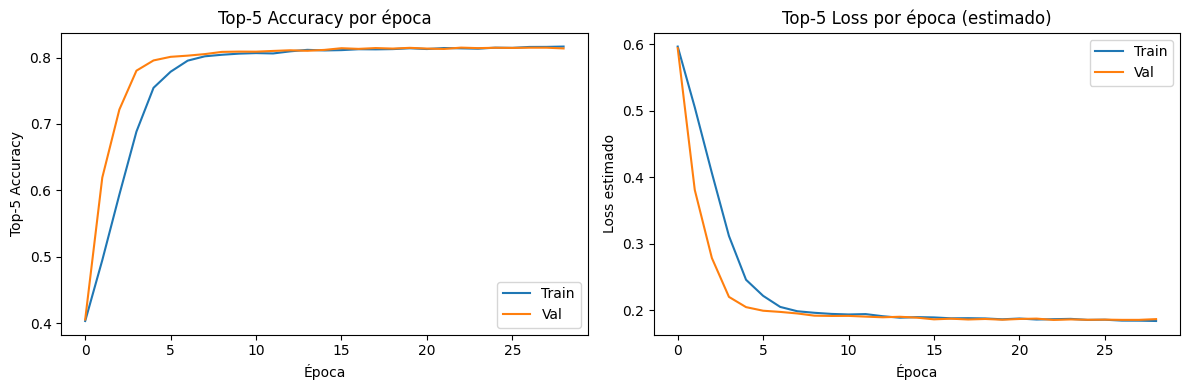

In [ ]:
# 9. Guardar modelo
os.makedirs("modelos", exist_ok=True)
modelo_nn_reentrenado.save("modelos/modelo_nn_reentrenado.keras")

# 10. Mostrar métricas finales
print("\n-> Modelo Reentrenado:")
print(f"Top-5 Accuracy (entrenamiento): {history.history['top_5_accuracy'][-1]:.4f}")
print(f"Top-5 Loss (entrenamiento): {history.history['top_5_loss'][-1]:.4f}")
print(f"Top-5 Accuracy (validación): {history.history['val_top_5_accuracy'][-1]:.4f}")
print(f"Top-5 Loss (validación): {history.history['val_top_5_loss'][-1]:.4f}")
print("\n-> Modelo guardado como 'modelos/modelo_nn_reentrenado.keras'")

# 11. Gráficas
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['top_5_accuracy'], label='Train')
plt.plot(history.history['val_top_5_accuracy'], label='Val')
plt.title('Top-5 Accuracy por época')
plt.xlabel('Época')
plt.ylabel('Top-5 Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['top_5_loss'], label='Train')
plt.plot(history.history['val_top_5_loss'], label='Val')
plt.title('Top-5 Loss por época (estimado)')
plt.xlabel('Época')
plt.ylabel('Loss estimado')
plt.legend()

plt.tight_layout()
plt.show()

# Output del nuevo modelo

In [ ]:
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Cargar modelos desde carpeta local
modelo_nn_reentrenado = load_model("modelo_nn_reentrenado.keras")

# 1. Transformar entrada real
entrada = transformar_input_real(
    año=2025,
    mes=6,
    día=14,
    nombre_dia='Viernes',
    turno='Tarde',
    sector_nombre='Sto.Dominguito'
)

print("Entrada transformada:")
print(entrada)

# preparar variables para la red
categorical_cols = ['turno_cod', 'sector_cod', 'zona_cod', 'dia_semana_cod']
numeric_cols = ['año', 'mes', 'día', 'es_fin_semana']
target_col = 'grupo_incidente_cod'

# 3. Top-5 con RED NEURONAL
entrada_cat = [np.array([entrada[col]]) for col in categorical_cols]
entrada_num = np.array([[entrada[col] for col in numeric_cols]])

probas_nn = modelo_nn_reentrenado.predict(entrada_cat + [entrada_num], verbose=0)

top5_idx_nn = np.argsort(probas_nn[0])[::-1][:5]
top5_probs_nn = probas_nn[0][top5_idx_nn]

# Convertir índices a strings para buscar en el JSON
top5_grupos_nn = [mapa_grupo.get(str(i), f"Clase {i}") for i in top5_idx_nn]


print("\n-> Top-5 predicción con Red Neuronal reentrenada:")
for i, (grupo, prob) in enumerate(zip(top5_grupos_nn, top5_probs_nn), 1):
    print(f"{i}. {grupo} ({prob*100:.2f}%)")

Entrada transformada:
{'año': 2025, 'mes': 6, 'día': 14, 'dia_semana_cod': 4, 'es_fin_semana': 0, 'turno_cod': 2, 'sector_cod': 53, 'zona_cod': 1}

-> Top-5 predicción con Red Neuronal reentrenada:
1. Consumo de sustancias (17.44%)
2. Robos (13.77%)
3. Seguridad ciudadana (10.82%)
4. Apoyo y asistencia (10.32%)
5. Violencia (9.06%)
